In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, sys
import json
import random
import torch
import torch.nn.functional as F
import pytorch3d

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.spatial.transform import Rotation as Rotation
import shapely
from shapely.geometry import Polygon

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.io import IO
from pytorch3d.io.experimental_gltf_io import MeshGlbFormat, load_meshes

# Data structures and functions for rendering
from pytorch3d.transforms import Transform3d
from pytorch3d.structures import Meshes, join_meshes_as_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation,
    PerspectiveCameras,
    PointLights, 
    DirectionalLights,
    AmbientLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,
    SoftPhongShader,
    HardPhongShader,
    SoftGouraudShader,
    HardGouraudShader,
    HardFlatShader,
    SoftSilhouetteShader,
    TexturesUV,
    TexturesVertex,
    TexturesAtlas,
    BlendParams
)

from pytorch3d.renderer.mesh.shader import ShaderBase, HardDepthShader
from pytorch3d.renderer.blending import hard_rgb_blend

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
    
torch.set_grad_enabled(False)
torch.cuda.empty_cache()

In [2]:
obj_paths = json.load(open("../data/3dfuture/obj_paths.json"))

# synset2cat = {'02818832': 'bed', '03001627': 'chair', '04256520': 'sofa', '04379243': 'table'}
# cat2synset = {v: k for k, v in synset2cat.items()}
obj_map = {cat: [] for cat in obj_paths}
for cat in obj_paths:
    for p in obj_paths[cat]:
        obj_id = p.split('/')[-2]
        obj_map[cat].append(obj_id)

In [3]:
def load_3dfront_obj(obj_filename, load_textures=True):
    verts, faces, aux = load_obj(
        obj_filename,
        load_textures=load_textures,
        device=device
    )
    textures = None
    if load_textures:
        # TexturesUV type
        tex_maps = aux.texture_images
        if tex_maps is not None and len(tex_maps) > 0:
            verts_uvs = aux.verts_uvs.to(device)  # (V, 2)
            faces_uvs = faces.textures_idx.to(device)  # (F, 3)
            image = list(tex_maps.values())[0].to(device)[None]
            textures = TexturesUV(verts_uvs=[verts_uvs], faces_uvs=[faces_uvs], maps=image)

    return verts, faces.verts_idx, textures

In [4]:
chair_idx = np.random.choice(len(obj_map['chair']))
chair_id = obj_map['chair'][chair_idx]

table_idx = np.random.choice(len(obj_map['table']))
table_id = obj_map['table'][table_idx]

sofa_idx = np.random.choice(len(obj_map['sofa']))
sofa_id = obj_map['sofa'][sofa_idx]

bed_idx = np.random.choice(len(obj_map['bed']))
bed_id = obj_map['bed'][bed_idx]

In [5]:
verts1, faces1, textures1 = load_3dfront_obj(obj_paths['chair'][chair_idx])
verts2, faces2, textures2 = load_3dfront_obj(obj_paths['table'][table_idx])
verts3, faces3, textures3 = load_3dfront_obj(obj_paths['sofa'][sofa_idx])
verts4, faces4, textures4 = load_3dfront_obj(obj_paths['bed'][bed_idx])

In [63]:
table_id
# 79364352-1dd7-34c9-8af5-6b17f69b9b02 large dimension

'79364352-1dd7-34c9-8af5-6b17f69b9b02'

In [6]:
x_min, z_min = verts1[:, [0,2]].min(0)[0].cpu().numpy()
x_max, z_max = verts1[:, [0,2]].max(0)[0].cpu().numpy()
short_side = min(x_max-x_min, z_max-z_min) / 2
corners = [[x_min, z_min], [x_max, z_min], [x_max, z_max], [x_min, z_max]]
a1 = np.random.rand() * 360
rot_mat = Rotation.from_euler('Z', a1, degrees=True).as_matrix()[:2, :2]
rot_corners = (rot_mat @ np.array(corners).T).T

x_min2, z_min2 = verts2[:, [0,2]].min(0)[0].cpu().numpy()
x_max2, z_max2 = verts2[:, [0,2]].max(0)[0].cpu().numpy()
short_side2 = min(x_max2-x_min2, z_max2-z_min2) / 2
corners2 = [[x_min2, z_min2], [x_max2, z_min2], [x_max2, z_max2], [x_min2, z_max2]]
a2 = np.random.rand() * 360
rot_mat2 = Rotation.from_euler('Z', a2, degrees=True).as_matrix()[:2, :2]
rot_corners2 = (rot_mat2 @ np.array(corners2).T).T

x_min3, z_min3 = verts3[:, [0,2]].min(0)[0].cpu().numpy()
x_max3, z_max3 = verts3[:, [0,2]].max(0)[0].cpu().numpy()
short_side3 = min(x_max3-x_min3, z_max3-z_min3) / 2
corners3 = [[x_min3, z_min3], [x_max3, z_min3], [x_max3, z_max3], [x_min3, z_max3]]
a3 = np.random.rand() * 360
rot_mat3 = Rotation.from_euler('Z', a3, degrees=True).as_matrix()[:2, :2]
rot_corners3 = (rot_mat3 @ np.array(corners3).T).T

x_min4, z_min4 = verts4[:, [0,2]].min(0)[0].cpu().numpy()
x_max4, z_max4 = verts4[:, [0,2]].max(0)[0].cpu().numpy()
short_side4 = min(x_max4-x_min4, z_max4-z_min4) / 2
corners4 = [[x_min4, z_min4], [x_max4, z_min4], [x_max4, z_max4], [x_min4, z_max4]]
a4 = np.random.rand() * 360
rot_mat4 = Rotation.from_euler('Z', a4, degrees=True).as_matrix()[:2, :2]
rot_corners4 = (rot_mat4 @ np.array(corners4).T).T

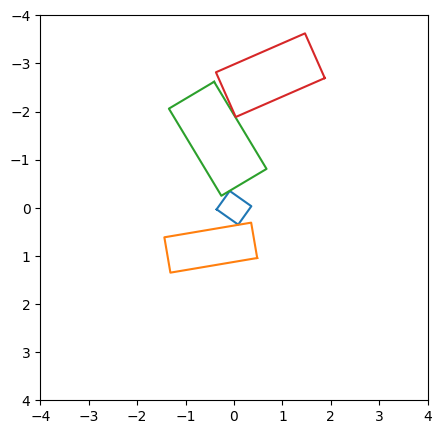

In [7]:
move1 = np.array([0,0,0])
p1 = Polygon(rot_corners)
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.invert_yaxis() #here I need to invert axis
ax.plot(*p1.exterior.xy)

vec = np.random.uniform(-1, 1, 2)
vec2 = vec / np.linalg.norm(vec)
base_dist = short_side + short_side2
move2 = base_dist * vec2
rot_corners2 += move2
p2 = Polygon(rot_corners2)
while p1.intersects(p2):
    base_dist += 0.05
    move2 = base_dist * vec2
    rot_corners2 += (vec2 * 0.05)
    p2 = Polygon(rot_corners2)
ax.plot(*p2.exterior.xy)

base_move = move2 / 2
vec = np.random.uniform(-1, 1, 2)
vec3 = vec / np.linalg.norm(vec)
base_dist = short_side + short_side2 + short_side3
move3 = base_dist * vec3 + base_move
rot_corners3 += move3
p3 = Polygon(rot_corners3)
while p1.intersects(p3) or p2.intersects(p3):
    base_dist += 0.05
    move3 = base_dist * vec3 + base_move
    rot_corners3 += (vec3 * 0.05)
    p3 = Polygon(rot_corners3)
ax.plot(*p3.exterior.xy)

base_move = (move2 + move3) / 3
vec = np.random.uniform(-1, 1, 2)
vec4 = vec / np.linalg.norm(vec)
base_dist = short_side + short_side2 + short_side3
move4 = base_dist * vec4 + base_move
rot_corners4 += move4
p4 = Polygon(rot_corners4)
while p1.intersects(p4) or p2.intersects(p4) or p3.intersects(p4):
    base_dist += 0.05
    move4 = base_dist * vec4 + base_move
    rot_corners4 += (vec4 * 0.05)
    p4 = Polygon(rot_corners4)
ax.plot(*p4.exterior.xy)

In [8]:
scene_corners = np.concatenate([np.array(rot_corners), np.array(rot_corners2), np.array(rot_corners3), np.array(rot_corners4)])
scene_center = (scene_corners.max(0) + scene_corners.min(0)) / 2

In [9]:
rot_mat1 = Rotation.from_euler('XYZ', [0, -a1, 0], degrees=True).as_matrix().astype(np.float32)
rot_mat1 = torch.tensor(rot_mat1, device=device)
trans_mat1 = np.array([move1[0]-scene_center[0], -torch.min(verts1[:, 1]).item(), move1[1]-scene_center[1]]).astype(np.float32)
trans_mat1 = torch.tensor(trans_mat1, device=device)
verts1 = (rot_mat1 @ verts1.T).T + trans_mat1
mesh1 = Meshes(
    verts=[verts1],
    faces=[faces1],
    textures=textures1,
)

rot_mat2 = Rotation.from_euler('XYZ', [0, -a2, 0], degrees=True).as_matrix().astype(np.float32)
rot_mat2 = torch.tensor(rot_mat2, device=device)
trans_mat2 = np.array([move2[0]-scene_center[0], -torch.min(verts2[:, 1]).item(), move2[1]-scene_center[1]]).astype(np.float32)
trans_mat2 = torch.tensor(trans_mat2, device=device)
verts2 = (rot_mat2 @ verts2.T).T + trans_mat2
mesh2 = Meshes(
    verts=[verts2],
    faces=[faces2],
    textures=textures2,
)

rot_mat3 = Rotation.from_euler('XYZ', [0, -a3, 0], degrees=True).as_matrix().astype(np.float32)
rot_mat3 = torch.tensor(rot_mat3, device=device)
trans_mat3 = np.array([move3[0]-scene_center[0], -torch.min(verts3[:, 1]).item(), move3[1]-scene_center[1]]).astype(np.float32)
trans_mat3 = torch.tensor(trans_mat3, device=device)
verts3 = (rot_mat3 @ verts3.T).T + trans_mat3
mesh3 = Meshes(
    verts=[verts3],
    faces=[faces3],
    textures=textures3,
)

rot_mat4 = Rotation.from_euler('XYZ', [0, -a4, 0], degrees=True).as_matrix().astype(np.float32)
rot_mat4 = torch.tensor(rot_mat4, device=device)
trans_mat4 = np.array([move4[0]-scene_center[0], -torch.min(verts4[:, 1]).item(), move4[1]-scene_center[1]]).astype(np.float32)
trans_mat4 = torch.tensor(trans_mat4, device=device)
verts4 = (rot_mat4 @ verts4.T).T + trans_mat4
mesh4 = Meshes(
    verts=[verts4],
    faces=[faces4],
    textures=textures4,
)

In [10]:
device = torch.device("cuda:0")
mesh = join_meshes_as_scene([mesh1, mesh2, mesh3, mesh4]).to('cuda')

In [81]:
# # Initialize a camera.
w, h = 1024, 1024
focal_length = 35 * w / 32
R, T = look_at_view_transform(5, 15, 0, at=((0,torch.mean(verts1[:, 1]),0),)) 
cameras = PerspectiveCameras(focal_length=focal_length, principal_point=((w//2, h//2),), device=device, R=R, T=T, in_ndc=False, image_size=((h, w),))

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0., 
    faces_per_pixel=20,
    cull_backfaces=True, # important for shapenet objects
#     bin_size=0,
)

# Place a point light in front of the object. ShapeNet objects are facing the -z direction. 
lights = PointLights(ambient_color=((0.7, 0.7, 0.7),), device=device, location=[[0.0, 1., 0.0]])

# Create a Flat renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

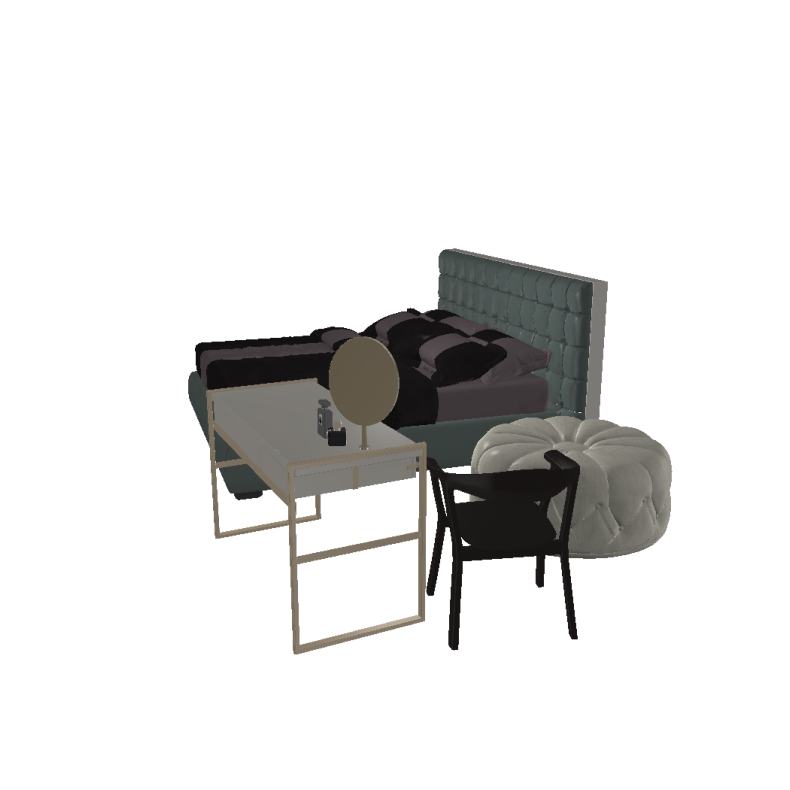

In [82]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
# plt.imshow(images[0, ..., 3].cpu().numpy() != 0)
# plt.imshow(images[0, ...,].cpu().numpy() / 100 *255)
plt.axis("off");